<div style="width:100vw;margin-left:calc(50% - 50vw);"><table width="100%" cellspacing="10" cellpadding="14" bgcolor="#f9fafb" style="border:1px solid #d1d5db;border-radius:12px;"><tr><td width="33%" align="center" valign="middle" bgcolor="#ffffff" style="border-radius:10px;"><a href="https://github.com/rikkirch/Computer_Pattern_and_Vision_Recognition/blob/main/Assignment/Assignment_1/Rikesh_Budhathoki_A1.ipynb" target="_parent"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" width="28"></a><br><span style="color:#000000;font-family:Georgia,serif;font-size:20px;font-weight:700;">View on GitHub</span></td><td width="33%" align="center" valign="middle" bgcolor="#ffffff" style="border-radius:10px;"><a href="https://nbviewer.org/github/rikkirch/Computer_Pattern_and_Vision_Recognition/blob/main/Assignment/Assignment_1/Rikesh_Budhathoki_A1.ipynb" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" width="28"></a><br><span style="color:#000000;font-family:Georgia,serif;font-size:20px;font-weight:700;">Open in nbviewer</span></td><td width="33%" align="center" valign="middle" bgcolor="#ffffff" style="border-radius:10px;"><a href="https://colab.research.google.com/github/rikkirch/Computer_Pattern_and_Vision_Recognition/blob/main/Assignment/Assignment_1/Rikesh_Budhathoki_A1.ipynb" target="_parent"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" width="28"></a><br><span style="color:#000000;font-family:Georgia,serif;font-size:20px;font-weight:700;">Run in Colab</span></td></tr></table></div>


### **Step 0: Mount Google Drive**

In Google Colab, the runtime environment is temporary, meaning any files uploaded directly to Colab are lost when the session ends. Since our calibration images are stored permanently in **Google Drive**, we need to mount Drive into Colab so that the notebook can access those files.

By mounting Google Drive:

* We can **read calibration images directly from Drive**
* We avoid re-uploading images every time the runtime restarts
* Our data remains **persistent and organized** across sessions

Once mounted, Google Drive behaves like a normal directory in the Colab file system, allowing us to load images using standard file paths.

This step must be done **before** accessing any images stored in Google Drive.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Step 1: Load Calibration Images from Google Drive**

In this step, the calibration images stored in Google Drive are accessed and prepared for processing.

After mounting Google Drive, the images are loaded from the specified directory using file-pattern matching. This allows the notebook to automatically collect all calibration images without manually listing each filename.

The main goals of this step are:

* to **verify that Google Drive is correctly mounted**
* to **confirm that all calibration images are accessible**
* to **ensure the correct number of images is loaded before proceeding**

This step does **not** perform any computer vision operations yet.
It serves as a validation step to confirm that the dataset is correctly located and ready for further processing.

If the images cannot be loaded correctly at this stage, subsequent steps such as corner detection and camera calibration will fail.

---

### **Outcome of this step**

* A list of calibration image file paths is successfully created
* The total number of images is confirmed
* The dataset is ready for grayscale conversion and chessboard corner detection

---

### **Why this step is important**

Camera calibration relies on multiple images taken from different viewpoints. Ensuring that all calibration images are properly loaded at the beginning helps avoid silent errors later in the pipeline and guarantees reproducibility of the results.

---

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
from tqdm import tqdm

In [3]:
img_paths = sorted(glob.glob("/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/*.jpeg"))
num_img = len(img_paths)
print(f"Number of images: {num_img}")
for path in img_paths:
    print(path)

Number of images: 12
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_1.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_10.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_11.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_12.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_2.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_3.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_4.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_5.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_6.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_7.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_8.jpeg
/content/drive/MyDrive/CSC_422/Assignment_1/Datasets/IMG_9.jpeg


## **Step 2: Detect Chessboard Inner Corners in Each Image**

In this step, we detect the **inner corner points** of the chessboard pattern in each calibration image. These inner corners correspond to the intersection points between adjacent black and white squares and are consistent across all images.

The purpose of this step is to establish a correspondence between:

* **Known 3D points in the real world** (defined by the chessboard geometry), and
* **Observed 2D points in the image** (pixel locations of the detected corners).

For each image, the chessboard is first converted to grayscale to simplify processing. Then, OpenCV’s chessboard corner detection algorithm is applied to locate the inner corners. If the expected number of corners is successfully detected, their pixel coordinates are stored and optionally visualized on the image for verification.

Accurate corner detection is crucial for reliable camera calibration. Images with motion blur, poor lighting, extreme viewing angles, or partial occlusion may fail to produce correct corner detections and should be excluded.

**Outcome of this step:**

* A list of 2D image points (pixel coordinates of inner corners) for each valid image
* A visual confirmation that the detected corners align correctly with the chessboard pattern

These detected image points are later used together with the known 3D world coordinates to compute the camera’s intrinsic and distortion parameters.

---

12it [00:20,  1.69s/it]


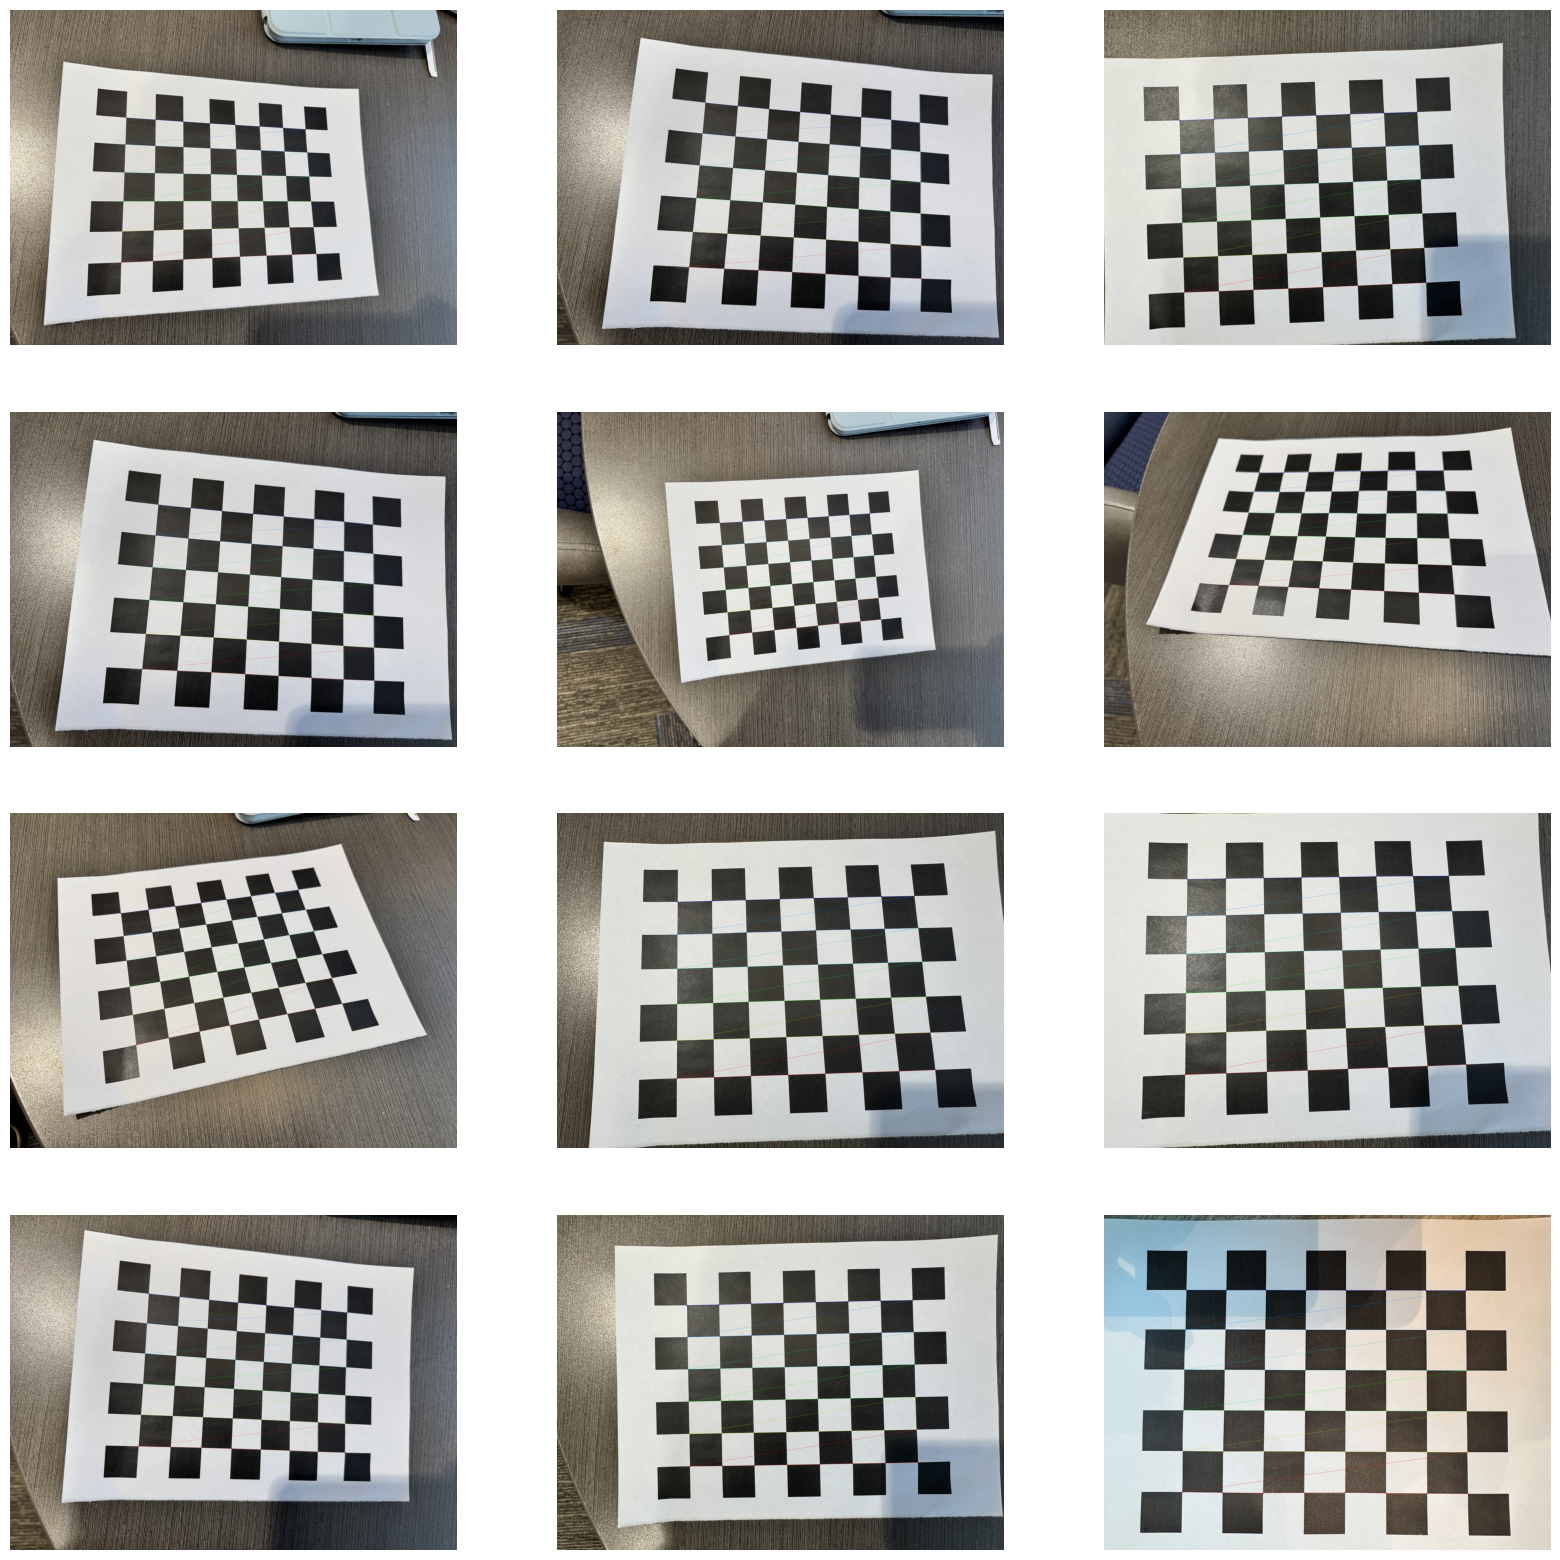

In [4]:
# ------------------------------------------------------------
# STEP 1: Define the chessboard pattern in the real world
# ------------------------------------------------------------

# pattern_size = (columns, rows) of INNER chessboard corners
# IMPORTANT: This must match the printed chessboard exactly
pattern_size = (8, 6)

# Physical size of one square edge on the chessboard
# We use 1.0 as unit length for now (can be mm or cm in real setups)
square_size = 1.00

# Create a template for 3D object points
# Each corner is represented as (X, Y, Z)
# Z = 0 because the chessboard lies on a flat plane
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)

# Fill X and Y coordinates with a grid like:
# (0,0), (1,0), (2,0), ..., (7,5)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

# Scale grid by the actual square size
pattern_points *= square_size

# Lists to store corresponding points from all images
# obj_points: 3D real-world coordinates (same for every image)
# img_points: 2D pixel coordinates detected in each image
obj_points = []
img_points = []

# Read the first image to get image height and width
# (Used earlier to ensure all images have same resolution)
h, w = cv2.imread(img_paths[0]).shape[:2]

# ------------------------------------------------------------
# STEP 2: Detect chessboard corners in each image
# ------------------------------------------------------------

plt.figure(figsize=(20, 20))

for i, img_path in tqdm(enumerate(img_paths)):

    # Load image from disk
    imgBGR = cv2.imread(img_path)
    if imgBGR is None:
        print("Failed to load", img_path)
        continue

    # Convert BGR (OpenCV default) → RGB for visualization
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    # Convert RGB → Grayscale (required for corner detection)
    img = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

    # Ensures all images have the same resolution
    # assert w == img.shape[1] and h == img.shape[0], \
    #        f"wrong image size: {img.shape[1]} x {img.shape[0]}"

    # --------------------------------------------------------
    # Detect chessboard corners using OpenCV
    # --------------------------------------------------------
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if not found:
        print(f"for {img_path}, chessboard not found")
        continue  # Skip this image if detection fails

    # --------------------------------------------------------
    # Store detected points ONLY if detection succeeded
    # --------------------------------------------------------

    # corners are detected in image pixel coordinates
    img_points.append(corners.reshape(-1, 2))

    # pattern_points are the corresponding real-world coordinates
    obj_points.append(pattern_points)

    # --------------------------------------------------------
    # Visualization: show first 12 images with detected corners
    # --------------------------------------------------------
    if i < 12:
        img_w_corners = cv2.drawChessboardCorners(
            imgRGB, pattern_size, corners, found
        )
        plt.subplot(4, 3, i + 1)
        plt.imshow(img_w_corners)
        plt.axis('off')

plt.show()


## Step 3: Camera Calibration (Intrinsic & Distortion Parameters)

In this step, we estimate the **camera intrinsic parameters** and **lens distortion coefficients** using the detected chessboard corners from all calibration images.

OpenCV provides the function `cv2.calibrateCamera`, which computes a camera model by minimizing the **reprojection error** between observed image points and projected 3D points.

### Function Used

```python
cv2.calibrateCamera()
```

### Inputs

* **obj_points**:
  A list of 3D points representing the real-world coordinates of the chessboard corners.
  These points lie on a flat plane (Z = 0) and are the same for every image.

* **img_points**:
  A list of 2D points representing the detected pixel coordinates of chessboard corners in each image.

* **(w, h)**:
  The image resolution (width, height).
  All calibration images must have the same size.

### Outputs

The function returns the following values:

* **RMS reprojection error** (`rms`):
  Measures how well the estimated camera model fits the observed data.
  It represents the average pixel distance between detected corners and reprojected corners.
  Smaller values indicate better calibration accuracy.

* **Camera intrinsic matrix** (`camera_matrix`):
  A 3×3 matrix containing the intrinsic parameters of the camera:

  * ( f_x, f_y ): focal lengths in pixel units
  * ( c_x, c_y ): principal point (optical center)

* **Distortion coefficients** (`dist_coefs`):
  Parameters that model lens distortion, including:

  * Radial distortion (k₁, k₂, k₃)
  * Tangential distortion (p₁, p₂)

* **Rotation vectors** (`_rvecs`) and **translation vectors** (`_tvecs`):
  These describe the pose (orientation and position) of the chessboard relative to the camera for each image.
  They are not used directly in this step but are required for reprojection and pose estimation.

### Printed Results

* The **reprojection error** provides a quantitative measure of calibration quality.
* The **intrinsic camera matrix** defines how 3D points are projected onto the image plane.
* The **distortion coefficients** are later used to undistort images and correct lens warping.

In [5]:
#calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("reprojection error:", rms)
print("3x3 intrinsic camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

reprojection error: 7.762700035783931
3x3 intrinsic camera matrix:
 [[3.72518211e+03 0.00000000e+00 2.85368647e+03]
 [0.00000000e+00 3.76822409e+03 2.32184571e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 0.10424291 -0.52269983 -0.01078877  0.00567062  0.54563128]


## Step 4: Image Undistortion Using Calibration Parameters

In this step, the estimated **camera intrinsic matrix** and **distortion coefficients** are used to correct lens distortion in the calibration images.

The OpenCV function `cv2.undistort` removes radial and tangential distortion, producing images where straight lines appear straight. This verifies the effectiveness of the calibration and prepares images for further computer vision tasks.

The undistorted results for the first 12 images are visualized for comparison.

12it [00:09,  1.25it/s]


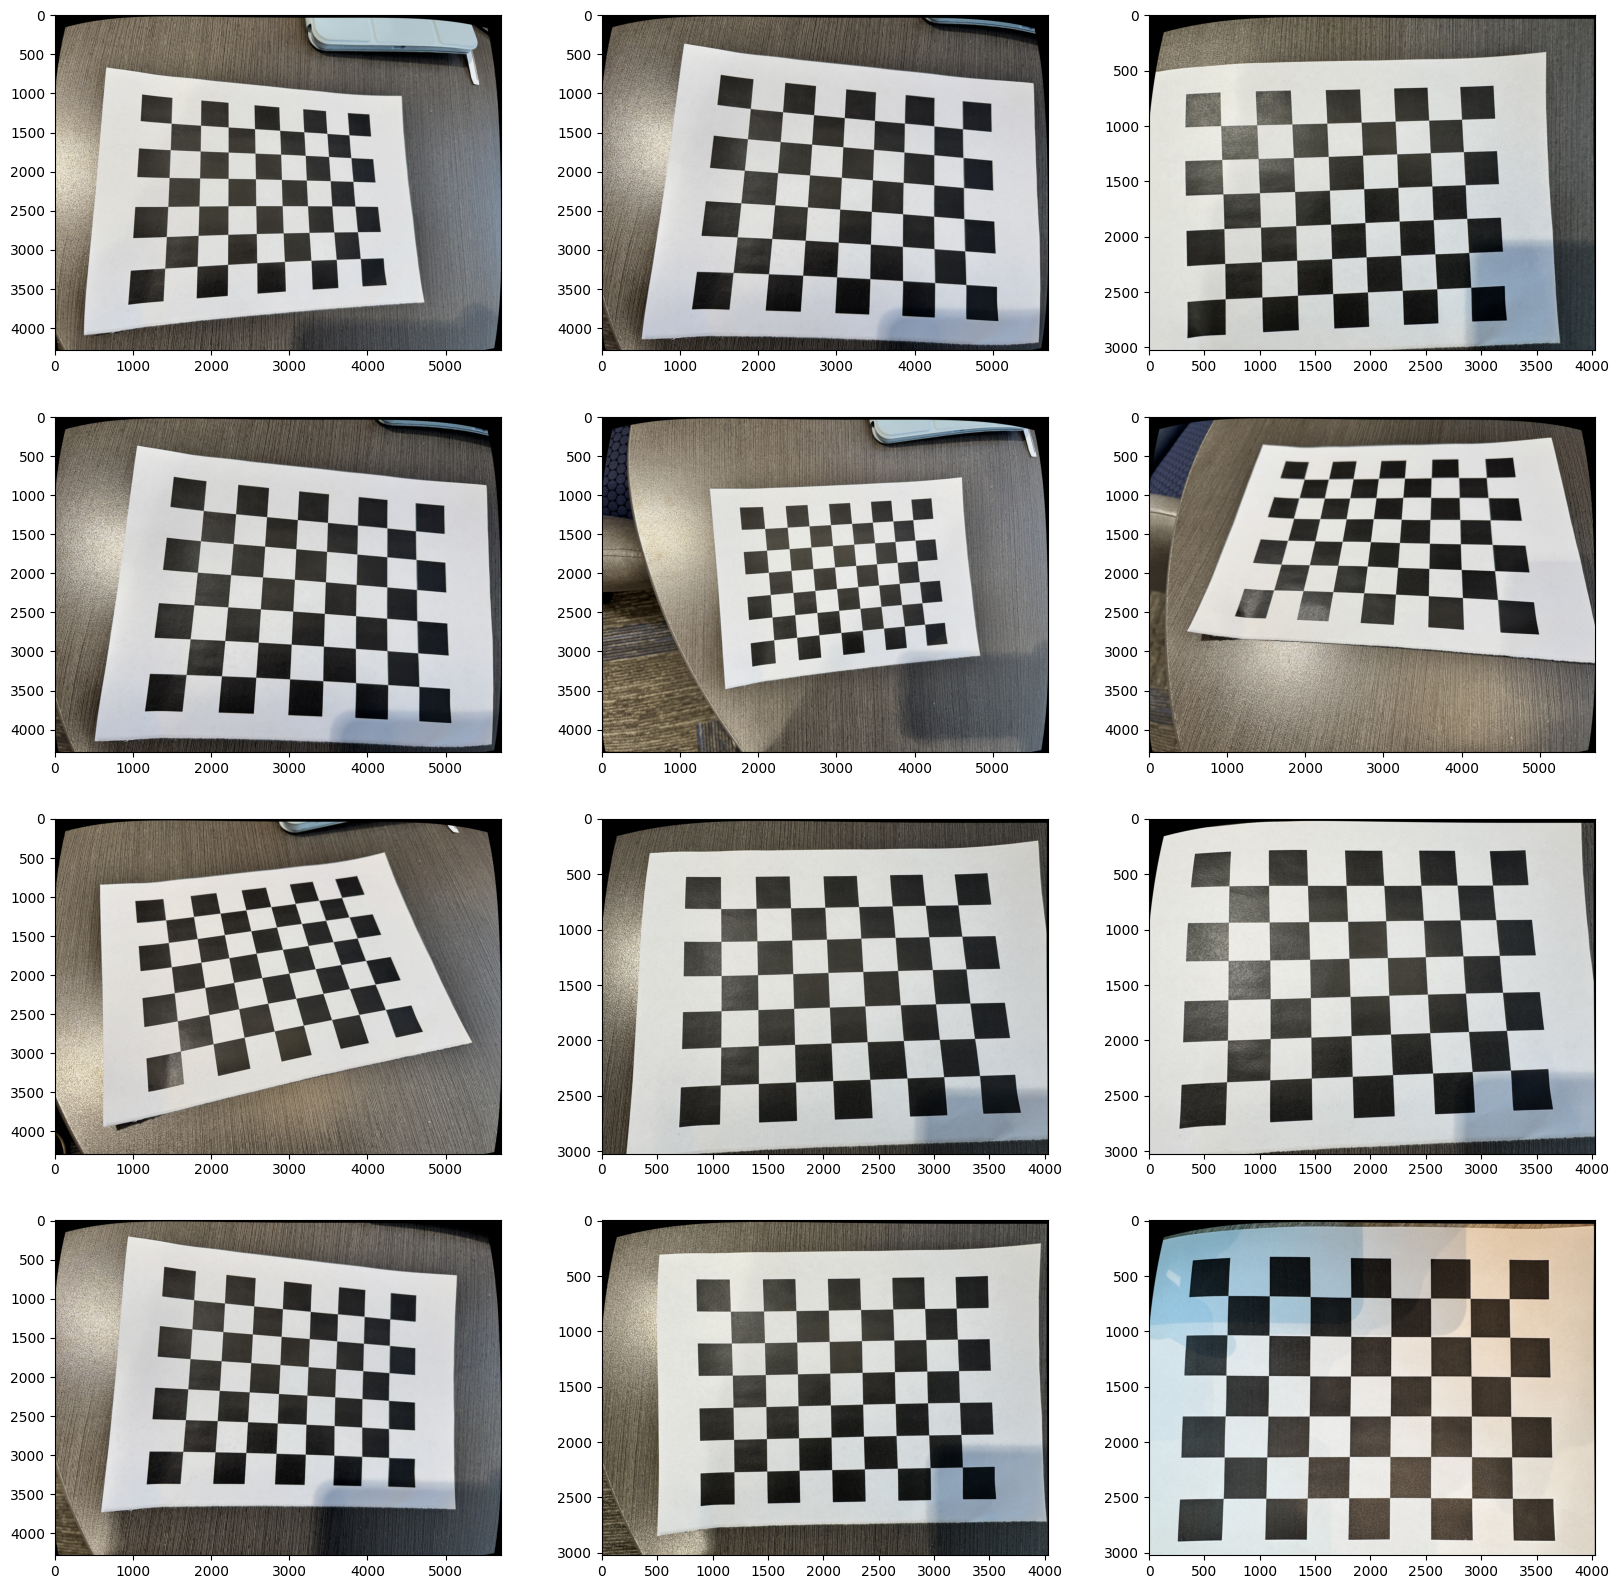

In [6]:
# undistort the image with the calibration
plt.figure(figsize=(20,20))
for i, fn in tqdm(enumerate(img_paths)):
    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    if i < 12:
      plt.subplot(4, 3, i + 1)
      plt.imshow(dst)
plt.show()

## Bonus: Effect of Number of Images on Calibration Accuracy

In this bonus experiment, camera calibration was performed using **different numbers of calibration images** to study how the amount of data affects calibration accuracy.

Subsets of detected images were selected, and `cv2.calibrateCamera` was applied to each subset. The resulting **RMS reprojection error** was recorded as a quantitative measure of calibration quality.

A plot of reprojection error versus number of images shows that using **more calibration images generally reduces error and stabilizes the camera parameters**, while calibration with fewer images results in higher error due to insufficient geometric constraints.


--- Running Bonus Analysis ---

[Subset Size: 5 images]
  -> RMS Reprojection Error: 3.28492

[Subset Size: 8 images]
  -> RMS Reprojection Error: 7.78937

[Subset Size: 10 images]
  -> RMS Reprojection Error: 8.09155

[Subset Size: 12 images]
  -> RMS Reprojection Error: 7.76270


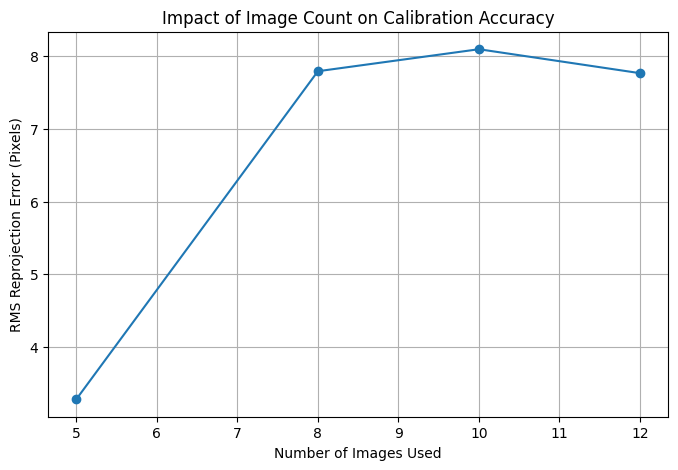

In [8]:
h, w = cv2.imread(img_paths[0]).shape[:2]
image_size = (w, h)

# Define different subset sizes to test
subset_sizes = [5, 8, 10, len(obj_points)]
results_error = []
used_sizes = []  # keeps the x-values aligned if anything gets skipped

print("--- Running Bonus Analysis ---")

for count in subset_sizes:
    # Ensure we don't try to use more images than we actually detected
    if count > len(obj_points):
        print(f"Skipping {count} images (only {len(obj_points)} available).")
        continue

    # 1) Select a subset of the detected correspondences
    subset_obj = obj_points[:count]
    subset_img = img_points[:count]

    # 2) Run Calibration on this subset
    ret_val, mtx_val, dist_val, rvecs_val, tvecs_val = cv2.calibrateCamera(
        subset_obj, subset_img, image_size, None, None
    )

    # 3) Store the result
    results_error.append(ret_val)
    used_sizes.append(count)

    print(f"\n[Subset Size: {count} images]")
    print(f"  -> RMS Reprojection Error: {ret_val:.5f}")

# 4) Plot the comparison
plt.figure(figsize=(8, 5))
plt.plot(used_sizes, results_error, marker='o', linestyle='-')
plt.title("Impact of Image Count on Calibration Accuracy")
plt.xlabel("Number of Images Used")
plt.ylabel("RMS Reprojection Error (Pixels)")
plt.grid(True)
plt.show()


## Difficulties I faced in this assignment
* Some images failed chessboard corner detection due to **partial board visibility**, **blur**, **strong perspective distortion**, **dark background** and **uneven lighting**.
* The `findChessboardCorners` function is sensitive to image quality, requiring several images to be replaced with cleaner ones.
* An **image-size assertion check failed**, even though all images were captured using the same camera, due to **resolution and orientation differences**, which required careful image selection.
* Interpreting the **intrinsic camera matrix**, **distortion coefficients**, and **reprojection error** required additional analysis to validate calibration quality.